In [2]:
from frame_semantic_transformer import FrameSemanticTransformer
import pickle
import logging
import spacy
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

logger = logging.getLogger()

/Users/avtk/miniconda3/envs/riveterEnv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/avtk/miniconda3/envs/riveterEnv/lib/python3.9/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [3]:
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])

### Lexicons for Action Verbs and Physical Consequences associated with War & Conflict

In [40]:
with open('../../data/lexicons/custom-lexicon-physical-consequences-war.txt', 'rb') as f:
    consequences_lexicon = f.read().decode('utf-8').split('\n')
    consequences_lexicon = [x.lower() for x in consequences_lexicon]

with open('../../data/lexicons/custom-lexicon-action-verbs.txt', 'rb') as f:
    action_verbs_lexicon = f.read().decode('utf-8').split('\n')
    action_verbs_lexicon = [x.lower() for x in action_verbs_lexicon]

with open('../../data/lexicons/visible_effects.txt', 'rb') as f:
    visible_effects = f.read().decode('utf-8').split('\n')
    visible_effects = [x.lower() for x in visible_effects]

with open('../../data/lexicons/framenet_visible_effects.txt', 'rb') as f:
    framenet_frames = f.read().decode('utf-8').split('\n')
    framenet_frames = [x.lower() for x in framenet_frames]

with open('../../data/lexicons/framenet_invisible_effects.txt', 'rb') as f:
    invisible_effects = f.read().decode('utf-8').split('\n')
    invisible_effects = [x.lower() for x in invisible_effects]

In [5]:
"quantified_mass" in framenet_frames

True

### Filtered dataset for US, UK, Middle East

In [6]:
def read_file(filename: str):
    data = pd.read_csv(filename)
    return data 

UK = read_file('../../data/raw/selected_data/selected_UK.csv')
ME = read_file('../../data/raw/selected_data/selected_MiddleEast.csv')
US = read_file('../../data/raw/selected_data/selected_US.csv')

print(UK.shape)
print(ME.shape)
print(US.shape)

(8150, 10)
(4145, 10)
(9629, 10)


In [19]:
# read all pickles related to ME 
with open('../../data/processed/frame_semantics/frame_semantics_MiddleEast.pickle', 'rb') as f:
    ME_1 = pickle.load(f)
print(len(ME_1["frame_semantics"]))

with open('../../data/processed/frame_semantics/frame_semantics_MiddleEast_batch_2.pickle', 'rb') as f:
    ME_2 = pickle.load(f)
print(len(ME_2["frame_semantics"]))

with open('../../data/processed/frame_semantics/frame_semantics_MiddleEast_batch_3.pickle', 'rb') as f:
    ME_3 = pickle.load(f)
print(len(ME_3["frame_semantics"]))

# combine all ME data
ME_frame_semantics = {}
ME_frame_semantics["frame_semantics"] = ME_1["frame_semantics"] + ME_2["frame_semantics"] + ME_3["frame_semantics"]
ME_frame_semantics["index"] = ME_1["index"] + ME_2["index"] + ME_3["index"] 

len(ME_frame_semantics["frame_semantics"])


1300
300
600


2200

### NER on selected Docs

In [13]:
def read_pickle_file(filename: str):
    with open(filename, 'rb') as f:
        data = pickle.load(f)
        return data

UK_headline_ner = read_pickle_file('../../data/processed/ner/ner_UK_main.pickle')
ME_headline_ner = read_pickle_file('../../data/processed/ner/ner_MiddleEast_main.pickle')
US_headline_ner = read_pickle_file('../../data/processed/ner/ner_US_main.pickle')

UK_maintext_ner = read_pickle_file('../../data/processed/ner/ner_UK_headline.pickle')
ME_maintext_ner = read_pickle_file('../../data/processed/ner/ner_MiddleEast_headline.pickle')
US_maintext_ner = read_pickle_file('../../data/processed/ner/ner_US_headline.pickle')

UK_preprocessed = read_pickle_file('../../data/processed/preprocessed/processed_documents_UK.pkl')
ME_preprocessed = read_pickle_file('../../data/processed/preprocessed/processed_documents_ME.pkl')
US_preprocessed = read_pickle_file('../../data/processed/preprocessed/processed_documents_US.pkl')

print(list(UK_headline_ner.keys()))
print(len(UK_headline_ner['index']), len(UK_headline_ner['ner_output']))
print(len(ME_headline_ner['index']), len(ME_headline_ner['ner_output']))
print(len(US_headline_ner['index']), len(US_headline_ner['ner_output']))

print(len(UK_maintext_ner['index']), len(UK_maintext_ner['ner_output']))
print(len(ME_maintext_ner['index']), len(ME_maintext_ner['ner_output']))
print(len(US_maintext_ner['index']), len(US_maintext_ner['ner_output']))


['index', 'ner_output']
0 9092
0 6307
0 9895
18183 9092
12613 6307
19789 9895


In [20]:
import string
from collections import Counter
from collections import defaultdict
from spacy.tokens import Doc
from collections import Counter
from typing import List, Dict, Set

def preprocess_lexicon(lexicon):

    doc = nlp(" ".join(lexicon)) 

    # Perform lemmatization and remove stopwords and punctuation
    lemmas = [token.lemma_.lower() for token in doc
              if not token.is_stop and not token.is_punct]

    return lemmas

def count_lexicon_words(doc: spacy.tokens.doc.Doc, lexicon: Set[str]) -> Dict[str, int]:
    """
    Count occurrences of lexicon words in a spaCy Doc object.
    
    Args:
    doc (spacy.tokens.doc.Doc): The processed document.
    lexicon (set of str): A set containing lexicon words.
    
    Returns:
    dict: A dictionary with lexicon words as keys and their counts as values.
    """
    # Filter tokens in the document to find those that are in the lexicon
    # Convert tokens to lower case for case insensitive matching
    words = [token.text.lower() for token in doc if token.text.lower() in lexicon]
    
    # Count occurrences of each word
    word_count = Counter(words)
    
    return dict(word_count)

In [21]:
ner_outputs = [output[0] for output in ME_maintext_ner['ner_output']]

# Add the LEXICON here. 
processed_lexicon = preprocess_lexicon(visible_effects)

all_counts = [count_lexicon_words(article, set(processed_lexicon)) for article in UK_preprocessed]
total_counts = defaultdict(int)
for article_counts in all_counts:
    for word, count in article_counts.items():
        total_counts[word] += count


In [16]:
sorted_total_counts = dict(sorted(total_counts.items(), key=lambda item: item[1], reverse=True))
#sorted_total_counts

In [ ]:
"""
def find_co_occurrences_with_counts(ner_outputs, lexicon):
    # Initialize a dictionary to hold counts of each lexicon word
    word_counts = {word: 0 for word in lexicon}
    count = 0
    doc_count = 0
    
    # Iterate through each document's NER outputs (list of lists like [word, entity_type])
    for document in ner_outputs:
        doc_count += 1
        token_list = []
        # Create a set to hold unique lexicon words found in this document
        found_lexicon_words = set()
        
        # Flags to check if any cardinal entity exists in the document
        has_cardinality = any(token[3] == "CARDINAL" for token in document if len(document)>0)
        # If a cardinal entity is present, proceed to check for lexicon words
        if has_cardinality:
            count += 1
            # Check each token and update if it's a lexicon word
            token_list.extend([token for token in document])
            print(token_list)
        
        # Update counts for each found lexicon word in this document
        for word in found_lexicon_words:
            word_counts[word] += 1
    print(count, doc_count)
    return word_counts


# Get co-occurrences
counts = find_co_occurrences_with_counts(ner_outputs, visible_effects)
print(counts)
sorted_total_counts = dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))
sorted_total_counts"""

'\ndef find_co_occurrences_with_counts(ner_outputs, lexicon):\n    # Initialize a dictionary to hold counts of each lexicon word\n    word_counts = {word: 0 for word in lexicon}\n    count = 0\n    doc_count = 0\n    \n    # Iterate through each document\'s NER outputs (list of lists like [word, entity_type])\n    for document in ner_outputs:\n        doc_count += 1\n        token_list = []\n        # Create a set to hold unique lexicon words found in this document\n        found_lexicon_words = set()\n        \n        # Flags to check if any cardinal entity exists in the document\n        has_cardinality = any(token[3] == "CARDINAL" for token in document if len(document)>0)\n        # If a cardinal entity is present, proceed to check for lexicon words\n        if has_cardinality:\n            count += 1\n            # Check each token and update if it\'s a lexicon word\n            token_list.extend([token for token in document])\n            print(token_list)\n        \n        # Up

In [17]:
"""import pickle
with open("../../data/processed/frame_semantics/frame_semantics_UK_main.pickle", "rb") as f: 
    UK_frame_semantics = pickle.load(f)
"""

'import pickle\nwith open("../../data/processed/frame_semantics/frame_semantics_UK_main.pickle", "rb") as f: \n    UK_frame_semantics = pickle.load(f)\n'

In [22]:
"""Function to count frames and their counts in a list of FrameSemanticTransformer objects."""

def count_occurrences_frames(frame_semantics: list):
    """
    Count occurrences of frames in a list of FrameSemanticTransformer objects.
    
    Args:
    frame_semantics (list[FrameSemanticTransformer]): A list of FrameSemanticTransformer objects.
    
    Returns:
    dict: A dictionary with frames as keys and their counts as values.
    """
    # Initialize a dictionary to hold counts of each frame
    frame_counts = {}
    
    # Iterate through each FrameSemanticTransformer object
    for document in frame_semantics['frame_semantics']:
        for sentence in document:
            for frame in sentence.frames:
                # Get the frame name
                current_frame = frame.name.lower()
                
                # Update the count for this frame
                if current_frame in frame_counts:
                    frame_counts[current_frame] += 1
                else:
                    frame_counts[current_frame] = 1
    
    return frame_counts


In [23]:
frame_counts = count_occurrences_frames(ME_frame_semantics)

In [24]:
relevant = {frame for frame in frame_counts if frame in framenet_frames}
relevant_counts = {frame: frame_counts[frame] for frame in relevant}

relevant_counts

{'surrendering': 3,
 'violence': 26,
 'military_operation': 13,
 'buildings': 2801,
 'destroying': 827,
 'committing_crime': 1241,
 'firing': 34,
 'killing': 3587,
 'explosion': 100,
 'rebellion': 4,
 'counterattack': 2,
 'subversion': 8,
 'death': 654,
 'hostile_encounter': 3911,
 'attack': 4781,
 'besieging': 330,
 'terrorism': 471,
 'quantified_mass': 2192}

886
{'statement': 14942, 'leadership': 5527, 'political_locales': 5490, 'attack': 4781, 'people': 3933, 'hostile_encounter': 3911, 'killing': 3587, 'buildings': 2801, 'military': 2571, 'calendric_unit': 2448, 'intentionally_act': 2383, 'attributed_information': 2364, 'locale': 2301, 'discussion': 2224, 'quantified_mass': 2192, 'aggregate': 2142, 'arriving': 2072, 'increment': 1959, 'causation': 1816, 'assistance': 1775, 'request': 1756, 'people_by_age': 1626, 'inclusion': 1595, 'kinship': 1469, 'attempt': 1288, 'committing_crime': 1241, 'judgment_communication': 1200, 'proportional_quantity': 1199, 'relative_time': 1193, 'interior_profile_relation': 1161, 'process_continue': 1148, 'locale_by_use': 1085, 'cardinal_numbers': 1066, 'cause_harm': 1042, 'businesses': 991, 'telling': 983, 'importance': 938, 'taking_sides': 938, 'weapon': 938, 'convey_importance': 934, 'event': 926, 'time_vector': 921, 'measure_duration': 899, 'vehicle': 897, 'existence': 870, 'residence': 863, 'emotion_direc

/var/folders/66/7zn69qrn4cg38jdkg3kkzj_m0000gr/T/ipykernel_2211/428220591.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(top_frames.values()), y=list(top_frames.keys()), palette="crest",saturation=0.8)


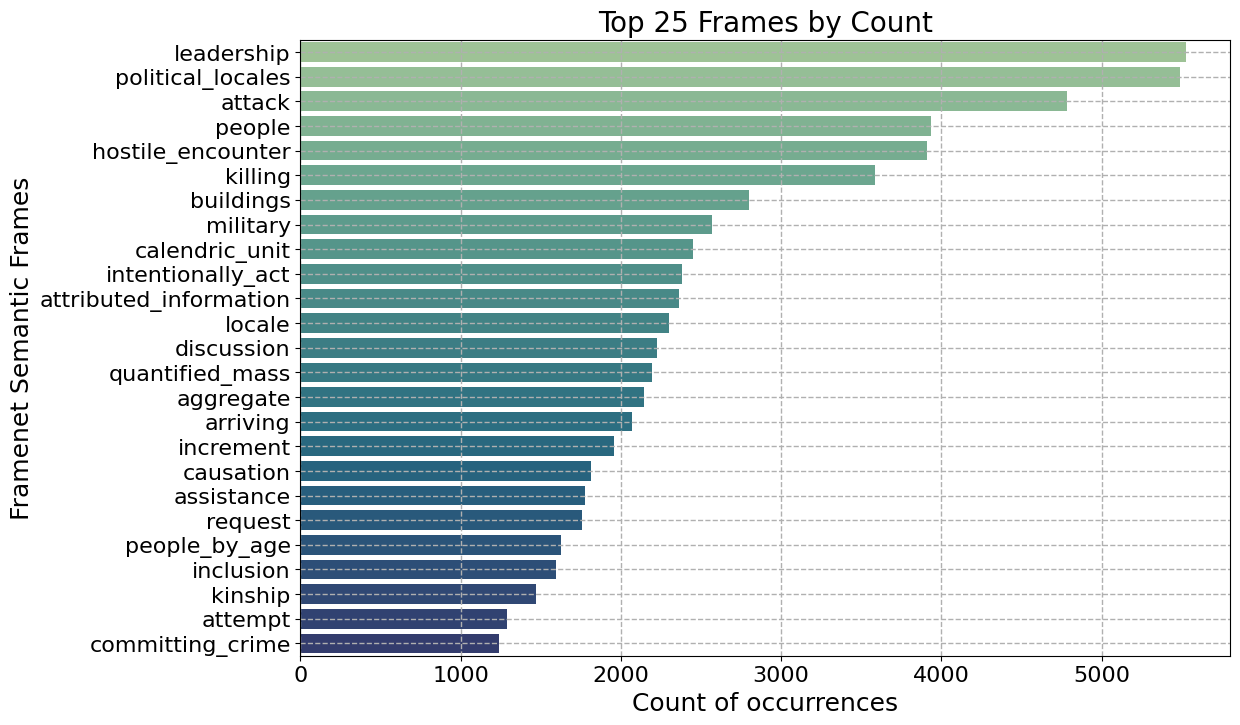

In [26]:
frame_counts = count_occurrences_frames(ME_frame_semantics)
print(len(frame_counts))

# sort frame counts
sorted_frame_counts = dict(sorted(frame_counts.items(), key=lambda item: item[1], reverse=True)) 
print(sorted_frame_counts)

filtered_frames = {frame: count for frame, count in sorted_frame_counts.items() if count>1000 and count < 6000}

# plot semantic frames 
import matplotlib.pyplot as plt
import seaborn as sns
sns.light_palette("seagreen", as_cmap=True)

def plot_frame_counts(frame_counts: dict, top_n: int = 30):
    """
    Plot the top N frames by count.
    
    Args:
    frame_counts (dict): A dictionary with frames as keys and their counts as values.
    top_n (int): The number of top frames to plot.
    """
    # Get the top N frames
    top_frames = dict(list(frame_counts.items())[:top_n])
    
    # Create a bar plot
    plt.figure(figsize=(12, 8))
    custom_pallette = sns.color_palette("mako", as_cmap=True)
    sns.barplot(x=list(top_frames.values()), y=list(top_frames.keys()), palette="crest",saturation=0.8)
    plt.grid(axis="both", linestyle="--", linewidth=1)
    plt.xlabel("Count of occurrences", fontsize=18)
    plt.ylabel("Framenet Semantic Frames", fontsize=18)
    plt.title(f"Top {top_n} Frames by Count", fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.show()

plot_frame_counts(filtered_frames, top_n=25)

In [27]:
from collections import Counter

# Collect all verbs from relevant frames
all_verbs = [verb for verb in lemmatized_frames["death"]]

# Count frequencies
verb_counts = Counter(all_verbs)

# Get the most common verbs
common_verbs = verb_counts.most_common(100)

NameError: name 'lemmatized_frames' is not defined

In [30]:
def parse_frame_semantic_results(frame_semantics):
    """ Function to parse frame semantics and extract occurrences of Quantified_mass and corresponding frame elements"""
    all_results = []
    co_occurring_frames = []
    sentence_frames_results = []
    for document_frames in frame_semantics['frame_semantics']: 
        for sentence_frames in document_frames:
            for frame in sentence_frames.frames:
            # Check if the frame's name matches the desired frame name
                if frame.name.lower() == "quantified_mass" or frame.name.lower() == "cardinal_numbers":
                    for frame_element in frame.frame_elements: 
                        co_occurring_frames.append(frame_element.text)
                    sentence_frames_results.append(sentence_frames)
                    # If a match is found, return the details of this frame
                    frame_result =  {
                        'name': frame.name,
                        'frame_elements': [{'name': fe.name, 'text': fe.text} for fe in frame.frame_elements]
                    }
                    all_results.append(frame_result)
    return sentence_frames_results,co_occurring_frames, all_results

sentence_frames_results, co_occurring_frames, all_results = parse_frame_semantic_results(ME_frame_semantics)

In [31]:
""" Function to count the occurrneces of cooccurring frames iterating over a list of frame element results """ 
def identify_co_occurring_frames(documents, context_window):
    # Dictionary to hold pairs of co-occurring frames and their counts
    co_occurrences = {}

    all_results = []
    for document in documents:
        # Iterate through each document
        for i, doc in enumerate(document):
            # For each frame in the current document
            for frame in doc.frames:
                # Define the context range based on the current sentence index and context window
                context_range_start = max(0, i - context_window)
                context_range_end = min(len(document), i + context_window + 1)
                
                # Check frames in the context range
                for j in range(context_range_start, context_range_end):
                    # Skip the current sentence to only look at surrounding sentences
                    if j == i:
                        continue
                    
                    # For each frame in the context sentences
                    for context_frame in document[j].frames:
                        # Create a sorted tuple of the current frame and the context frame
                        frame_pair = tuple(sorted([frame.name, context_frame.name]))
                        
                        # Update the count of this frame pair in the dictionary
                        if frame_pair in co_occurrences:
                            co_occurrences[frame_pair] += 1
                        else:
                            co_occurrences[frame_pair] = 1
                        frame_result =  {
                            'name': context_frame.name,
                            'frame_elements': [{'name': fe.name, 'text': fe.text} for fe in context_frame.frame_elements]
                        }
                    all_results.append(frame_result)

    return co_occurrences

context_window = 1
co_occurrences = identify_co_occurring_frames(ME_frame_semantics['frame_semantics'], context_window)
#print(co_occurrences)
    

# Plot co-occurrences with varying context window

In [44]:
""" Function to count the occurrneces of cooccurring frames with a specific frame name as input - in the same sentence and a context window of 1 or 2 sentences """
def identify_co_occurring_frames_specific(documents, frame_name, context_window):
    # Dictionary to hold pairs of co-occurring frames and their counts
    co_occurrences = {}
    all_results = []
    # Iterate through each document
    for document in documents:
        for i, doc in enumerate(document):
            # For each frame in the current document
            for frame in doc.frames:
                # Check if the frame's name matches the desired frame name
                if frame.name.lower() == frame_name:
                    # Define the context range based on the current sentence index and context window
                    context_range_start = max(0, i - context_window)
                    context_range_end = min(len(document), i + context_window + 1)
                    
                    # Check frames in the context range
                    for j in range(context_range_start, context_range_end):
                        
                        # For each frame in the context sentences
                        for context_frame in document[j].frames:
                                                            # Create a sorted tuple of the current frame and the context frame
                            frame_pair = tuple(sorted([frame.name, context_frame.name]))

                            if context_frame.name.lower() in invisible_effects:  
                                # Update the count of this frame pair in the dictionary
                                if frame_pair in co_occurrences:
                                 co_occurrences[frame_pair] += 1
                                else:
                                 co_occurrences[frame_pair] = 1
                            

                                frame_result =  {
                                'name': context_frame.name,
                                'frame_elements': [{'name': fe.name, 'text': fe.text} for fe in context_frame.frame_elements]
                                }
                                all_results.append(frame_result)

    return all_results,co_occurrences

#all_results,co_occurrences = identify_co_occurring_frames_specific(ME_frame_semantics['frame_semantics'], "quantified_mass", 1)


In [45]:
# compute co_occurrences with frame_net frame for all framenet frames and plot them:
all_co_occurrences = {}
for frame in framenet_frames:
    all_results,co_occurrences = identify_co_occurring_frames_specific(ME_frame_semantics['frame_semantics'], frame, 3)
    for element,value in co_occurrences.items():
        if element in all_co_occurrences.keys():
            all_co_occurrences[element] = all_co_occurrences[element] + value
        else:
            all_co_occurrences[element] = value
print(all_co_occurrences)

# create co-occurrences matrix with all_co_occurrences
co_occurrences_matrix = pd.DataFrame(all_co_occurrences.items(), columns=['frame', 'count'])
co_occurrences_matrix.head()



{('Attack', 'Kinship'): 3130, ('Attack', 'Judgment'): 450, ('Attack', 'Being_at_risk'): 1510, ('Attack', 'Awareness'): 798, ('Attack', 'Being_obligated'): 618, ('Attack', 'Medical_conditions'): 886, ('Attack', 'Fear'): 242, ('Attack', 'Surviving'): 214, ('Attack', 'Emotion_directed'): 1310, ('Attack', 'Change_of_leadership'): 204, ('Attack', 'Experiencer_focus'): 342, ('Attack', 'Perception_experience'): 942, ('Attack', 'Communication'): 740, ('Attack', 'Stimulus_focus'): 380, ('Attack', 'Becoming_aware'): 534, ('Attack', 'Relational_political_locales'): 30, ('Attack', 'Recovery'): 52, ('Attack', 'Memory'): 50, ('Attack', 'Feeling'): 134, ('Attack', 'Opinion'): 344, ('Attack', 'Trust'): 28, ('Attack', 'Coming_to_believe'): 218, ('Attack', 'Forgiveness'): 8, ('Buildings', 'Memory'): 15, ('Buildings', 'Perception_experience'): 411, ('Buildings', 'Kinship'): 1314, ('Buildings', 'Medical_conditions'): 610, ('Buildings', 'Change_of_leadership'): 44, ('Buildings', 'Stimulus_focus'): 221, ('B

,frame,count
0,"(Attack, Kinship)",3130
1,"(Attack, Judgment)",450
2,"(Attack, Being_at_risk)",1510
3,"(Attack, Awareness)",798
4,"(Attack, Being_obligated)",618


(10, 10)


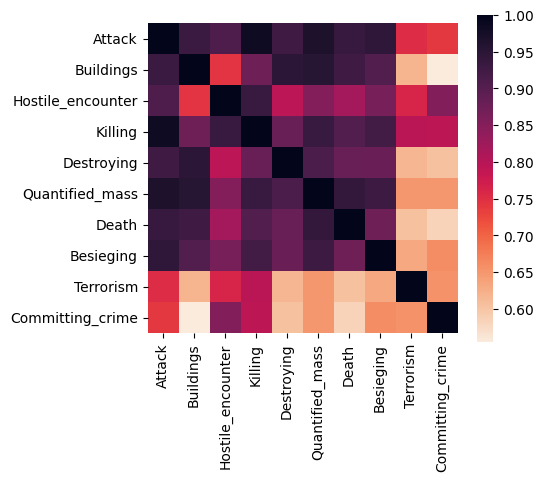

In [39]:
matrix_dict = defaultdict(lambda: defaultdict(int))

for (item1, item2), count in all_co_occurrences.items():
    matrix_dict[item1][item2] = count
    matrix_dict[item2][item1] = count
   #if item1 == item2:
   #     matrix_dict[item1][item2] = 0

matrix_df = pd.DataFrame(matrix_dict).fillna(0) 
matrix_df.shape

# remove rows and columns with all zeros
matrix_df = matrix_df.loc[:, (matrix_df > 500).any(axis=0)]
# remove columns with  all zeros 
matrix_df = matrix_df.loc[(matrix_df > 500).any(axis=1), :]
print(matrix_df.shape)

# plot matrix_df 
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
sns.heatmap(matrix_df.corr(), cmap="rocket_r", annot=False, fmt="g", cbar_kws={'shrink': 0.85}, square=True)
#plt.title("Co-occurrences of FrameNet Frames", fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()



In [36]:
# sort tuple containing strings alphabetically
sorted_all_co_occurrences = dict(sorted(all_co_occurrences.items(), key=lambda item: item[1], reverse=True))
sorted_all_co_occurrences

# plot all_co_occurrences



{('Attack', 'Attack'): 26242,
 ('Attack', 'Killing'): 15060,
 ('Attack', 'Buildings'): 12552,
 ('Attack', 'Hostile_encounter'): 11004,
 ('Hostile_encounter', 'Hostile_encounter'): 8527,
 ('Buildings', 'Buildings'): 8513,
 ('Killing', 'Killing'): 8205,
 ('Attack', 'Quantified_mass'): 7521,
 ('Hostile_encounter', 'Killing'): 5976,
 ('Buildings', 'Killing'): 4558,
 ('Buildings', 'Quantified_mass'): 4160,
 ('Quantified_mass', 'Quantified_mass'): 3828,
 ('Killing', 'Quantified_mass'): 3764,
 ('Attack', 'Committing_crime'): 3609,
 ('Buildings', 'Hostile_encounter'): 3170,
 ('Hostile_encounter', 'Quantified_mass'): 3084,
 ('Attack', 'Destroying'): 3021,
 ('Committing_crime', 'Committing_crime'): 3009,
 ('Committing_crime', 'Hostile_encounter'): 2674,
 ('Committing_crime', 'Killing'): 2460,
 ('Attack', 'Death'): 2262,
 ('Buildings', 'Destroying'): 1992,
 ('Attack', 'Terrorism'): 1659,
 ('Destroying', 'Killing'): 1454,
 ('Destroying', 'Destroying'): 1315,
 ('Destroying', 'Hostile_encounter'): 1

In [46]:
# compute co_occurrences with frame_net frame for all framenet frames and plot them:
all_co_occurrences = {}
for frame in invisible_effects:
    all_results,co_occurrences = identify_co_occurring_frames_specific(ME_frame_semantics['frame_semantics'], frame, 3)
    for element,value in co_occurrences.items():
        if element in all_co_occurrences.keys():
            all_co_occurrences[element] = all_co_occurrences[element] + value
        else:
            all_co_occurrences[element] = value
print(all_co_occurrences)

# create co-occurrences matrix with all_co_occurrences
co_occurrences_matrix = pd.DataFrame(all_co_occurrences.items(), columns=['frame', 'count'])
co_occurrences_matrix.head()



{('Emotion_directed', 'Stimulus_focus'): 108, ('Emotion_directed', 'Kinship'): 666, ('Emotion_directed', 'Emotion_directed'): 1165, ('Becoming_aware', 'Emotion_directed'): 116, ('Emotion_directed', 'Fear'): 50, ('Emotion_directed', 'Medical_conditions'): 276, ('Being_obligated', 'Emotion_directed'): 96, ('Emotion_directed', 'Perception_experience'): 218, ('Being_at_risk', 'Emotion_directed'): 372, ('Awareness', 'Emotion_directed'): 202, ('Emotion_directed', 'Experiencer_focus'): 128, ('Emotion_directed', 'Judgment'): 126, ('Change_of_leadership', 'Emotion_directed'): 78, ('Emotion_directed', 'Opinion'): 138, ('Emotion_directed', 'Relational_political_locales'): 6, ('Communication', 'Emotion_directed'): 136, ('Emotion_directed', 'Memory'): 20, ('Emotion_directed', 'Feeling'): 90, ('Emotion_directed', 'Surviving'): 28, ('Emotion_directed', 'Trust'): 2, ('Coming_to_believe', 'Emotion_directed'): 68, ('Emotion_directed', 'Recovery'): 8, ('Emotion_directed', 'Forgiveness'): 2, ('Cause_to_ex

,frame,count
0,"(Emotion_directed, Stimulus_focus)",108
1,"(Emotion_directed, Kinship)",666
2,"(Emotion_directed, Emotion_directed)",1165
3,"(Becoming_aware, Emotion_directed)",116
4,"(Emotion_directed, Fear)",50


(7, 7)


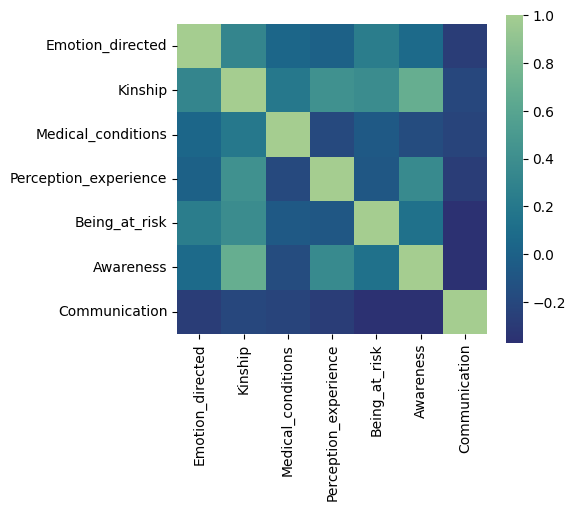

In [48]:
matrix_dict = defaultdict(lambda: defaultdict(int))

for (item1, item2), count in all_co_occurrences.items():
    matrix_dict[item1][item2] = count
    matrix_dict[item2][item1] = count
   #if item1 == item2:
   #     matrix_dict[item1][item2] = 0

matrix_df = pd.DataFrame(matrix_dict).fillna(0) 
matrix_df.shape

# remove rows and columns with all zeros
matrix_df = matrix_df.loc[:, (matrix_df > 500).any(axis=0)]
# remove columns with  all zeros 
matrix_df = matrix_df.loc[(matrix_df > 500).any(axis=1), :]
print(matrix_df.shape)

# plot matrix_df 
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
sns.heatmap(matrix_df.corr(), cmap="crest_r", annot=False, fmt="g", cbar_kws={'shrink': 0.85}, square=True)
#plt.title("Co-occurrences of FrameNet Frames", fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()



In [49]:
# find most common frame in a dcoument in the frame_semantic_transformer results
def find_most_common_frame(frame_semantics):
    most_common_frame = {}
    for document_frames in frame_semantics['frame_semantics']: 
        for sentence_frames in document_frames:
            for frame in sentence_frames.frames:
                if frame.name in most_common_frame:
                    most_common_frame[frame.name] += 1
                else:
                    most_common_frame[frame.name] = 1
    return most_common_frame
most_common_frame = find_most_common_frame(ME_frame_semantics)

# sort the most common frame
sorted_most_common_frame = dict(sorted(most_common_frame.items(), key=lambda item: item[1], reverse=True))
sorted_most_common_frame

{'Statement': 14942,
 'Leadership': 5527,
 'Political_locales': 5490,
 'Attack': 4781,
 'People': 3933,
 'Hostile_encounter': 3911,
 'Killing': 3587,
 'Buildings': 2801,
 'Military': 2571,
 'Calendric_unit': 2448,
 'Intentionally_act': 2383,
 'Attributed_information': 2364,
 'Locale': 2301,
 'Discussion': 2224,
 'Quantified_mass': 2192,
 'Aggregate': 2142,
 'Arriving': 2072,
 'Increment': 1959,
 'Causation': 1816,
 'Assistance': 1775,
 'Request': 1756,
 'People_by_age': 1626,
 'Inclusion': 1595,
 'Kinship': 1469,
 'Attempt': 1288,
 'Committing_crime': 1241,
 'Judgment_communication': 1200,
 'Proportional_quantity': 1199,
 'Relative_time': 1193,
 'Interior_profile_relation': 1161,
 'Process_continue': 1148,
 'Locale_by_use': 1085,
 'Cardinal_numbers': 1066,
 'Cause_harm': 1042,
 'Businesses': 991,
 'Telling': 983,
 'Importance': 938,
 'Taking_sides': 938,
 'Weapon': 938,
 'Convey_importance': 934,
 'Event': 926,
 'Time_vector': 921,
 'Measure_duration': 899,
 'Vehicle': 897,
 'Existence

In [50]:
print(ME.shape)

(4145, 10)


### Be careful with mapping indices, some might be missing

In [56]:
ME_frame_semantics_df = pd.DataFrame(ME_frame_semantics, columns=['frame_semantics', 'index'])
ME_frame_semantics_df.head()
# merge ME_frame_semantics_df with ME based on index of ME 
ME['index'] = ME.index
ME_merged = pd.merge(ME, ME_frame_semantics_df, on='index')
print(ME_merged.shape)




(2200, 12)


In [57]:
# extract document wise frames: 
def extract_document_frames(frame_semantics):
    all_results = []
    for document_frames in frame_semantics['frame_semantics']: 
        doc_frames = {}
        for sentence_frames in document_frames:
            for frame in sentence_frames.frames:
                if frame.name.lower() in doc_frames:
                    doc_frames[frame.name.lower()] += 1
                else:
                    doc_frames[frame.name.lower()] = 1
        all_results.append(doc_frames)
    return all_results

In [58]:
doc_frames = extract_document_frames(ME_merged)
print(len(doc_frames))

2200


In [68]:
# add doc_frames to UK dataframe subset 
ME_merged['doc_frames'] = doc_frames 
frames_df = pd.json_normalize(ME_merged['doc_frames'])
susbet_frames = [frame for frame in frames_df.columns if frame in framenet_frames]
frames_df = frames_df[susbet_frames]
ME_merged.columns
frames_df = pd.concat([ME_merged[['date_publish']], frames_df], axis=1)
frames_df['date_publish'] = pd.to_datetime(frames_df['date_publish'])
filtered_df = frames_df[frames_df['date_publish'].dt.year.isin([2023,2024])]
filtered_df = frames_df[frames_df['date_publish'].dt.month.isin([1,2,11,12])]

# Group by 'date_published' and sum the counts for each frame
aggregated_df = filtered_df.groupby('date_publish').sum()


<Figure size 800x1600 with 0 Axes>

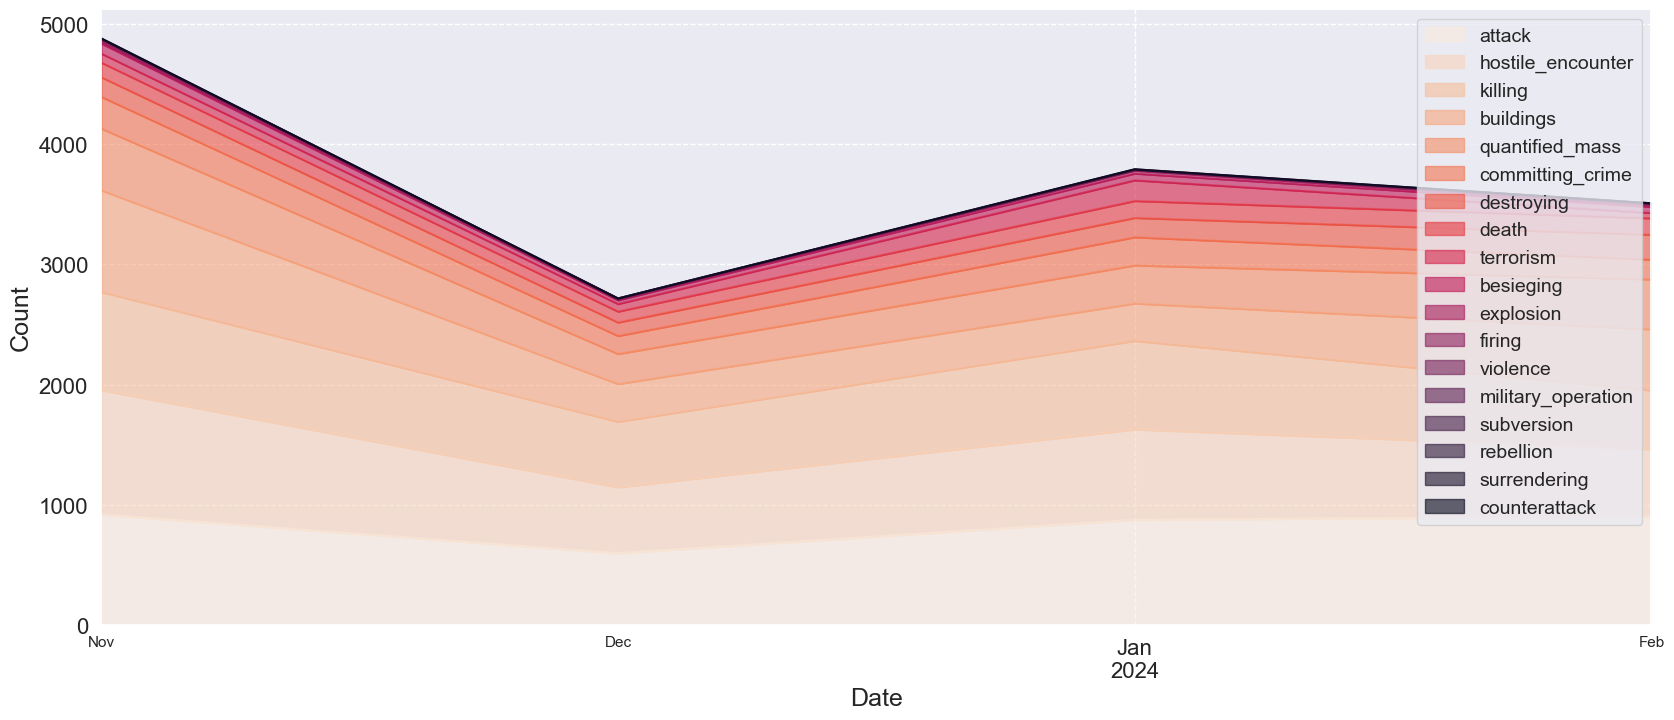

In [69]:
top_frames = aggregated_df.sum().sort_values(ascending=False).head(20).index
aggregated_df_monthly = aggregated_df.resample('ME').sum()
# make prettier by making a transparent stacked area plot 
plt.figure(figsize=(8, 16))
sns.set_theme(style="darkgrid")
sns.color_palette("viridis", as_cmap=True)
#sns.lineplot(data=aggregated_df_monthly[top_frames],palette="tab10", linewidth=2.5, alpha=0.7)
aggregated_df_monthly[top_frames].plot(kind='area', figsize=(20, 8), alpha=0.6, colormap="rocket_r")
#plt.title("Semantic Frame Counts Over Time (Monthly Aggregation)", fontsize=20)
plt.xlabel("Date", fontsize=18)
plt.ylabel("Count", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=14, loc='upper right')
plt.grid(axis='both', linestyle='--', linewidth=1)
plt.show()

<Figure size 800x1600 with 0 Axes>

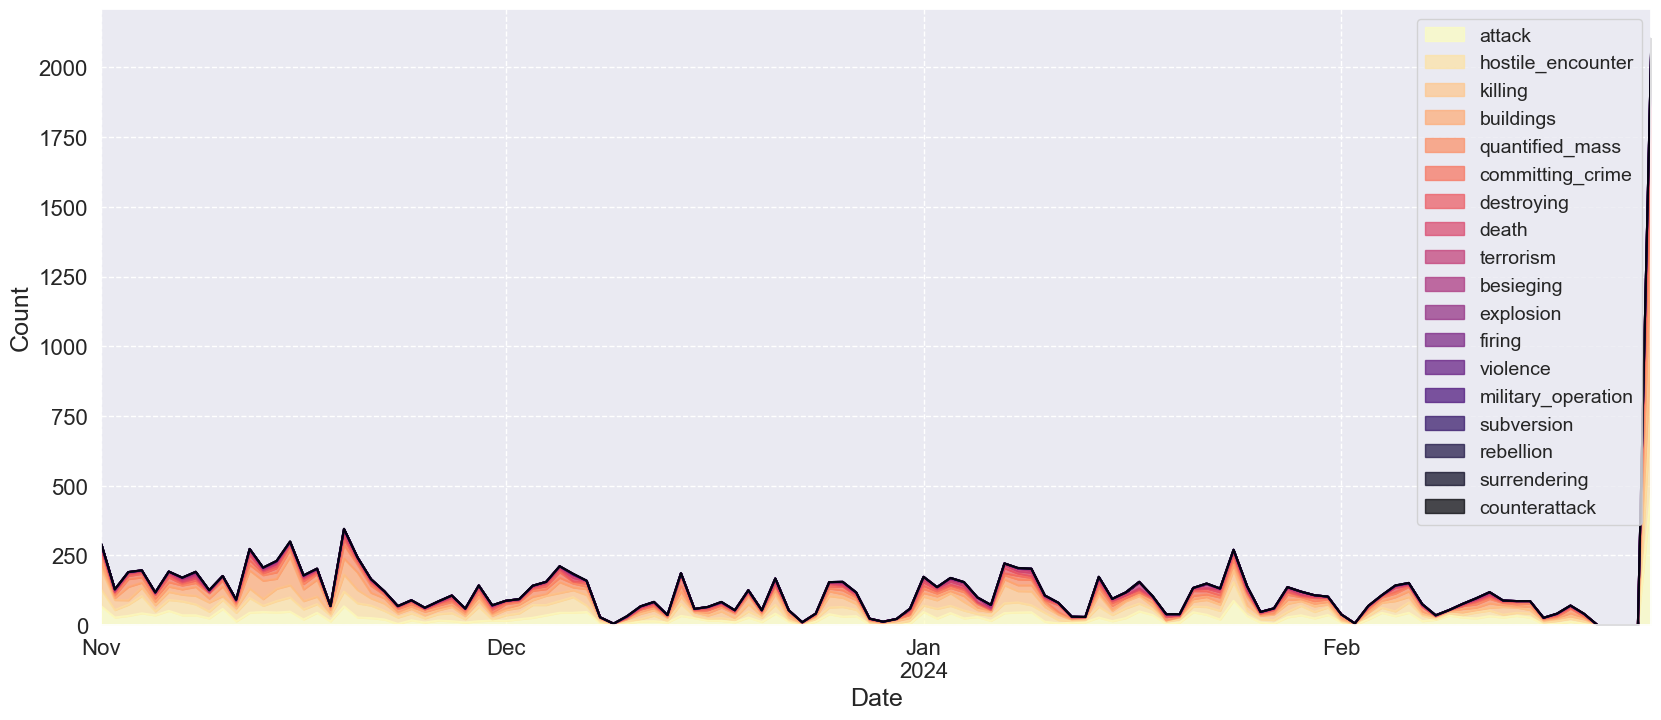

In [70]:
top_frames = aggregated_df.sum().sort_values(ascending=False).head(20).index
aggregated_df_monthly = aggregated_df.resample('D').sum()
# make prettier by making a transparent stacked area plot 
plt.figure(figsize=(8, 16))
sns.set_theme(style="darkgrid")
sns.color_palette("viridis", as_cmap=True)
#sns.lineplot(data=aggregated_df_monthly[top_frames],palette="tab10", linewidth=2.5, alpha=0.7)
aggregated_df_monthly[top_frames].plot(kind='area', figsize=(20, 8), alpha=0.7, colormap="magma_r")
#plt.title("Semantic Frame Counts Over Time (Monthly Aggregation)", fontsize=20)
plt.xlabel("Date", fontsize=18)
plt.ylabel("Count", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=14, loc='upper right')
plt.grid(axis='both', linestyle='--', linewidth=1)
plt.show()

In [77]:
# add doc_frames to UK dataframe subset 
ME_merged['doc_frames'] = doc_frames 
frames_df = pd.json_normalize(ME_merged['doc_frames'])
susbet_frames = [frame for frame in frames_df.columns if frame in invisible_effects]
frames_df = frames_df[susbet_frames]
ME_merged.columns
frames_df = pd.concat([ME_merged[['date_publish']], frames_df], axis=1)
frames_df['date_publish'] = pd.to_datetime(frames_df['date_publish'])
filtered_df = frames_df[frames_df['date_publish'].dt.year.isin([2023,2024])]

# Group by 'date_published' and sum the counts for each frame
aggregated_df = filtered_df.groupby('date_publish').sum()


<Figure size 800x1600 with 0 Axes>

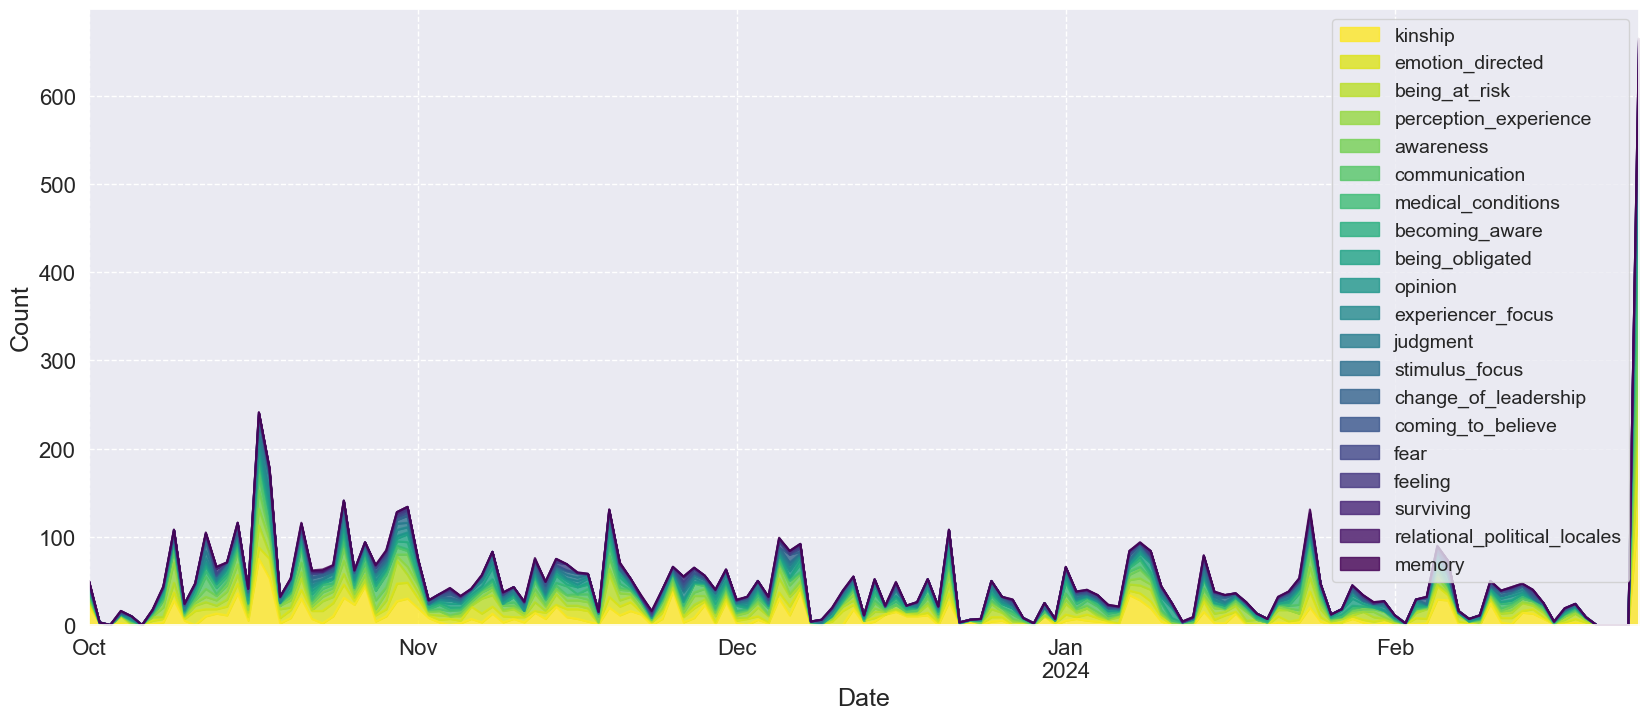

In [78]:
top_frames = aggregated_df.sum().sort_values(ascending=False).head(20).index
aggregated_df_monthly = aggregated_df.resample('D').sum()
# make prettier by making a transparent stacked area plot 
plt.figure(figsize=(8, 16))
sns.set_theme(style="darkgrid")
sns.color_palette("viridis", as_cmap=True)
#sns.lineplot(data=aggregated_df_monthly[top_frames],palette="tab10", linewidth=2.5, alpha=0.7)
aggregated_df_monthly[top_frames].plot(kind='area', figsize=(20, 8), alpha=0.8, colormap="viridis_r")
#plt.title("Semantic Frame Counts Over Time (Monthly Aggregation)", fontsize=20)
plt.xlabel("Date", fontsize=18)
plt.ylabel("Count", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=14, loc='upper right')
plt.grid(axis='both', linestyle='--', linewidth=1)
plt.show()

# MFC

In [ ]:
frame_annotated_data_df = pd.read_csv('../../data/processed/frame_annotated_data.csv')
frame_annotated_data_df = frame_annotated_data_df.drop(columns=['Unnamed: 0'])
frame_annotated_data_df["date_publish"] = pd.to_datetime(frame_annotated_data_df["date_publish"])

In [ ]:
frame_annotated_data_df.shape

(1811, 12)

In [ ]:
# combine frame_annotated_data_df with subset_UK dataframe based on the column "title" 
merged_df = pd.merge(subset_UK_df, frame_annotated_data_df, on='title', how='inner')
merged_df.columns


Index(['description_x', 'maintext_x', 'source_domain_x', 'title', 'url_x',
       'language_x', 'date_publish_x', 'region_x', 'title_len_x', 'text_len_x',
       'doc_frames', 'description_y', 'maintext_y', 'source_domain_y', 'url_y',
       'language_y', 'date_publish_y', 'region_y', 'title_len_y', 'text_len_y',
       'frame', 'reasoning'],
      dtype='object')

In [ ]:
merged_df["date_publish_x"] = pd.to_datetime(merged_df["date_publish_x"])
merged_df = merged_df[merged_df['date_publish_x'].dt.year.isin([2023,2024])]
merged_df = merged_df[["frame", "date_publish_x"]]

# Exploding the 'frames' column into separate rows for each frame
merged_df = merged_df.explode('frame')
merged_df.head()
merged_df.set_index('date_publish_x', inplace=True)

# filter merged_df to remove "ERROR" frame
merged_df = merged_df[merged_df["frame"] != "ERROR"]

In [ ]:
monthly_frame_counts = merged_df.groupby([pd.Grouper(freq='M'), 'frame']).size().unstack(fill_value=0)

/var/folders/66/7zn69qrn4cg38jdkg3kkzj_m0000gr/T/ipykernel_10560/262569201.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_frame_counts = merged_df.groupby([pd.Grouper(freq='M'), 'frame']).size().unstack(fill_value=0)


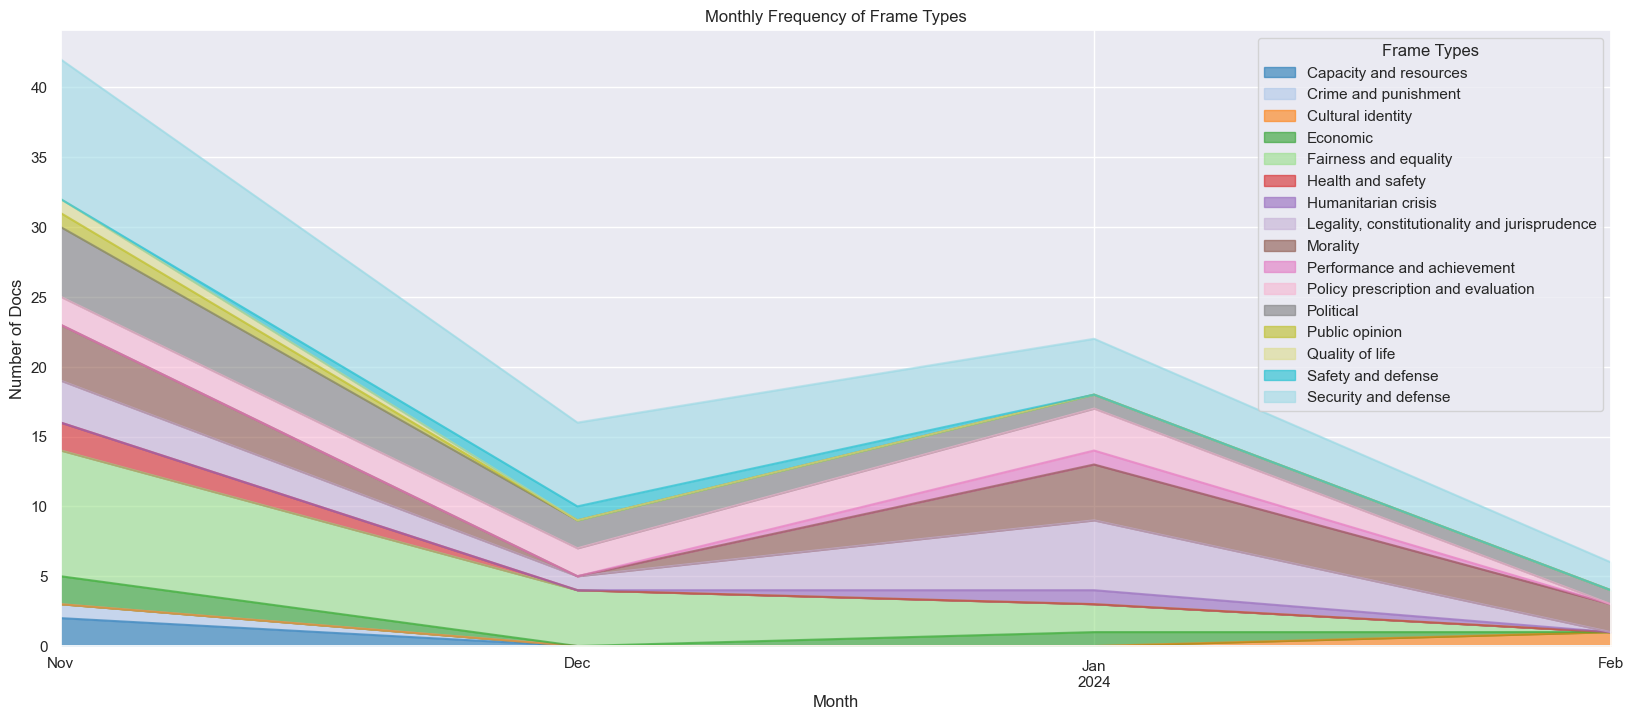

In [200]:
import matplotlib.pyplot as plt

# Plotting a stacked area chart
monthly_frame_counts.plot(kind='area', stacked=True, figsize=(20, 8), alpha=0.6, colormap='tab20') #tab20
plt.title('Monthly Frequency of Frame Types')
plt.xlabel('Month')
plt.ylabel('Number of Docs')
plt.legend(title='Frame Types', loc='upper right')
plt.show()